In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1
from phase_2.scripts.strategies.meta.meta_allocator_v1 import build_regime_features, build_meta_raw_returns_param_v1

from phase_3.strategies.meta.meta_allocator_soft_v1 import build_soft_meta_returns

from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting
from phase_2.scripts.strategies.portfolio.portfolio_constructor_v1 import (
    align_asset_returns,
    compute_inverse_vol_weights,
    build_portfolio_raw_returns,
)


In [4]:
ASSETS = ["SPY", "AAPL", "MSFT"]

data = {}
for sym in ASSETS:
    df = pd.read_parquet(f"../../phase_2/data/processed/{sym.lower()}_daily.parquet")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    data[sym] = df

years = sorted(data["SPY"]["year"].unique())


In [5]:
def sharpe_ratio(x):
    x = np.asarray(x, dtype=float)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(252) * np.nanmean(x) / np.nanstd(x)

def max_drawdown(eq):
    eq = np.asarray(eq, dtype=float)
    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0
    return np.nanmin(dd)


In [6]:
GAMMAS = [1.0, 1.5, 2.0, 3.0]


In [7]:
def run_soft_portfolio_walkforward(gamma: float) -> pd.DataFrame:
    portfolio_daily_all = []

    for test_year in years:
        asset_daily = {}

        for sym, df in data.items():
            train = df[df["year"] < test_year].copy()
            test  = df[df["year"] == test_year].copy()

            if len(train) < 500 or len(test) < 60:
                continue

            trend_out = run_trend_strategy_v1(test, train_df=train)
            meanrev_out = run_meanrev_strategy_v1(test)

            regime = build_regime_features(test)
            soft = build_soft_meta_returns(
                trend_out,
                meanrev_out,
                regime,
                gamma=gamma,
            )

            soft["asset"] = sym
            soft["year"] = test_year
            asset_daily[sym] = soft

        if len(asset_daily) != len(ASSETS):
            continue

        ret_wide = align_asset_returns(asset_daily)
        w_assets = compute_inverse_vol_weights(ret_wide, lookback=20, max_weight=0.70)
        port_raw = build_portfolio_raw_returns(ret_wide, w_assets)

        vt = apply_vol_targeting(
            port_raw, target_vol_annual=0.10, lookback=20, max_leverage=1.0
        )

        port = pd.DataFrame({
            "date": port_raw.index,
            "portfolio_ret": vt["meta_ret"].values,
            "portfolio_lev": vt["lev"].values,
            "year": test_year,
        })

        portfolio_daily_all.append(port)

    return (
        pd.concat(portfolio_daily_all)
        .sort_values("date")
        .reset_index(drop=True)
    )


In [8]:
rows = []
equity_curves = {}

for g in GAMMAS:
    port = run_soft_portfolio_walkforward(g)
    eq = (1 + port["portfolio_ret"]).cumprod()

    rows.append({
        "gamma": g,
        "sharpe": sharpe_ratio(port["portfolio_ret"].values),
        "total_return": eq.iloc[-1] - 1.0,
        "max_drawdown": max_drawdown(eq.values),
        "avg_leverage": port["portfolio_lev"].mean(),
    })

    equity_curves[g] = (port["date"], eq)

summary = pd.DataFrame(rows).sort_values("gamma").reset_index(drop=True)
summary


,gamma,sharpe,total_return,max_drawdown,avg_leverage
0,1.0,1.548501,1.464630,-0.074306,0.924183
1,1.5,1.725815,1.506400,-0.065789,0.924240
2,2.0,1.865809,1.474687,-0.060098,0.924149
3,3.0,2.056384,1.324157,-0.049461,0.924060


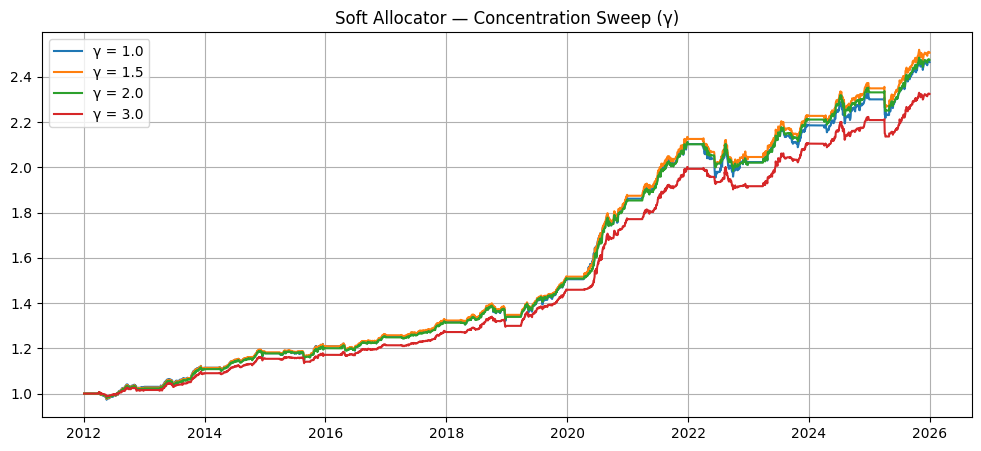

In [9]:
plt.figure(figsize=(12,5))
for g, (dts, eq) in equity_curves.items():
    plt.plot(dts, eq, label=f"γ = {g}")

plt.title("Soft Allocator — Concentration Sweep (γ)")
plt.legend()
plt.grid(True)
plt.show()
